In [1]:
%pip install peewee pytorch_lightning

Note: you may need to restart the kernel to use updated packages.


## Introduction
the project intention is to get an svg board image and predict how much advantage (or disadvantage) as the white player

In [1]:
# using peewee to open the file since it is a .db file (from lichess)
from peewee import *
import base64

db = SqliteDatabase('./database/chess_games.db')

class Evaluations(Model):
  id = IntegerField()
  fen = TextField()
  binary = BlobField()
  eval = FloatField()

  class Meta:
    database = db

  def binary_base64(self):
    return base64.b64encode(self.binary)
  
db.connect()

# LABEL_COUNT reprensts number of rows in the database
LABEL_COUNT = 37164639
print(LABEL_COUNT)

37164639


In [2]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, IterableDataset
from torchmetrics import Accuracy
from torchsummary import summary
import pytorch_lightning as pl
from random import randrange
from collections import OrderedDict

In [3]:
# Global settings to use with nvidia cuda gpu
torch.set_float32_matmul_precision('high')

In [4]:
class EvaluationDataset(IterableDataset):
  def __init__(self, count):
    self.count = count

  def __iter__(self):
    return self
  
  def __next__(self):
    idx = randrange(self.count)
    return self[idx]
  
  def __len__(self):
    return self.count
  
  def __getitem__(self, index):
    eval = Evaluations.get(Evaluations.id == index+1)
    bin = np.frombuffer(eval.binary, dtype=np.uint8)
    bin = np.unpackbits(bin, axis=0).astype(np.single)
    eval.eval = max(eval.eval, -15)
    eval.eval = min(eval.eval, 15)
    ev = np.array([eval.eval]).astype(np.single)
    return { 'binary': bin, 'eval': ev }
  
dataset = EvaluationDataset(count=LABEL_COUNT)

In [5]:
class EvaluationModel(pl.LightningModule):
  def __init__(self, learning_rate=1e-3, batch_size=512, layer_count=10):
    super().__init__()
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    layers = []
    for i in range(layer_count-1):
      layers.append((f'linear-{i}', nn.Linear(808, 808)))
      layers.append((f'relu-{i}', nn.ReLU()))
    layers.append((f'linear-{layer_count-1}', nn.Linear(808, 1)))
    self.seq = nn.Sequential(OrderedDict(layers))

  def forward(self, x):
    return self.seq(x)
  
  def training_step(self, batch):
    x, y = batch['binary'], batch['eval']
    y_hat = self(x)
    loss = F.l1_loss(y_hat, y)
    self.log('train_loss', loss)
    return loss
  
  def validation_step(self, batch): 
    x, y = batch 
    preds = self.forward(x) 
    loss = self.criterion(preds, y)
    accuracy = Accuracy()
    acc = accuracy(preds, y)
    self.log('accuracy', acc, on_epoch=True)
    return loss

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
  
  def train_dataloader(self):
    dataset = EvaluationDataset(count=LABEL_COUNT)
    return DataLoader(dataset, batch_size=self.batch_size, pin_memory=True)

In [7]:
import time

version_name = f'{int(time.time())}-batch_size-512-layer_count-10'
logger = pl.loggers.TensorBoardLogger("lightning_logs", name="chessml", version=version_name)
trainer = pl.Trainer(precision='16-mixed', max_epochs=1, accelerator='gpu')
model = EvaluationModel(layer_count=10, batch_size=512, learning_rate=1e-3)
print(model)
summary(model, (808,), device='cpu')
trainer.fit(model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\fedin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | seq  | Sequential | 5.9 M 
------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.535    Total estimated model params size (MB)


EvaluationModel(
  (seq): Sequential(
    (linear-0): Linear(in_features=808, out_features=808, bias=True)
    (relu-0): ReLU()
    (linear-1): Linear(in_features=808, out_features=808, bias=True)
    (relu-1): ReLU()
    (linear-2): Linear(in_features=808, out_features=808, bias=True)
    (relu-2): ReLU()
    (linear-3): Linear(in_features=808, out_features=808, bias=True)
    (relu-3): ReLU()
    (linear-4): Linear(in_features=808, out_features=808, bias=True)
    (relu-4): ReLU()
    (linear-5): Linear(in_features=808, out_features=808, bias=True)
    (relu-5): ReLU()
    (linear-6): Linear(in_features=808, out_features=808, bias=True)
    (relu-6): ReLU()
    (linear-7): Linear(in_features=808, out_features=808, bias=True)
    (relu-7): ReLU()
    (linear-8): Linear(in_features=808, out_features=808, bias=True)
    (relu-8): ReLU()
    (linear-9): Linear(in_features=808, out_features=1, bias=True)
  )
)
----------------------------------------------------------------
        Layer 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 72588/72588 [2:15:00<00:00,  8.96it/s, v_num=1]


Idx 10320330 Eval 1.70 Prediction 1.69 Loss 0.01
FEN r1bqk1nr/pp3pp1/2n1p2p/3pP3/2pP4/2P1PN2/PPQNB1PP/R4RK1 b kq - 0 11


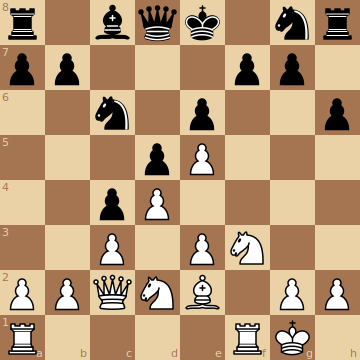

Idx 30984296 Eval 1.19 Prediction 1.03 Loss 0.16
FEN r1b1k2r/pp1pppb1/1q4pp/7n/2PP4/2N5/PP3PPP/R1BQKB1R w KQkq - 1 11


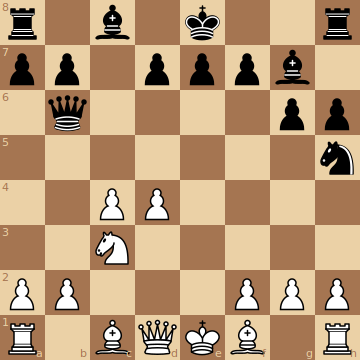

Idx 25302954 Eval -10.75 Prediction -14.62 Loss 3.87
FEN 8/Q7/1pkp1qp1/2p1p3/8/2PR1n1b/PP2K2P/8 b - - 2 33


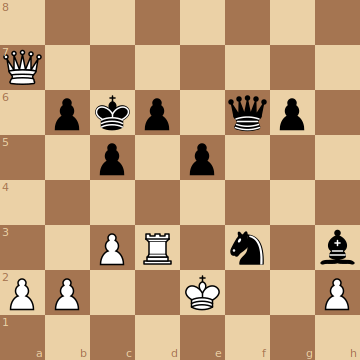

Idx 5264590 Eval 0.00 Prediction -1.48 Loss 1.48
FEN 6k1/1p3p1p/p3b1p1/3pP1P1/2qP3P/3N4/1P3Q1K/8 w - - 2 36


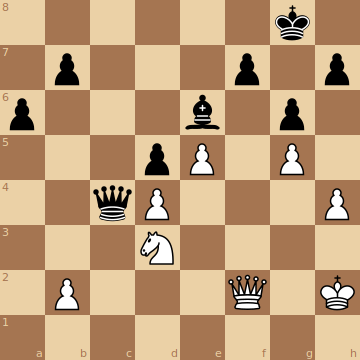

Idx 36284437 Eval -0.98 Prediction -0.49 Loss 0.49
FEN 8/pp3bpp/5p2/4pPP1/kP1pP2P/P2P4/1K6/5B2 b - - 2 41


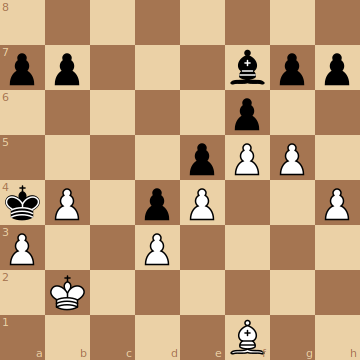

Idx 24808483 Eval -9.05 Prediction -9.41 Loss 0.36
FEN 1k6/pp3ppp/3n4/6p1/P2r1P1K/8/7P/4R3 w - - 0 33


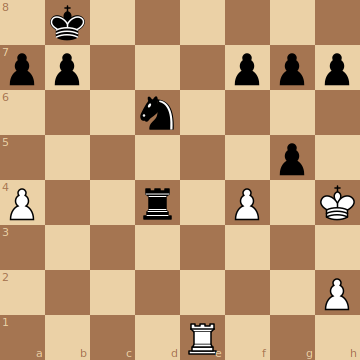

Idx 22020970 Eval 9.60 Prediction 8.61 Loss 0.99
FEN 4r3/p1pR2p1/1p4kp/2p5/5P2/7P/P1P2PP1/1R4K1 w - - 2 24


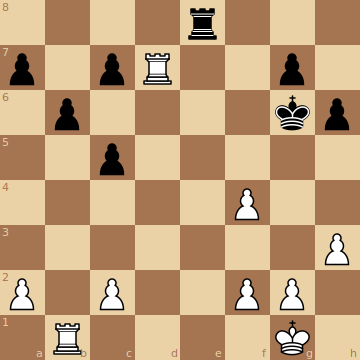

Idx 36240405 Eval -0.30 Prediction 0.26 Loss 0.56
FEN rnbqk1nr/ppp3pp/3p4/2b1pP2/2P5/5N1P/PP1P1PP1/RNBQKB1R b KQkq - 0 5


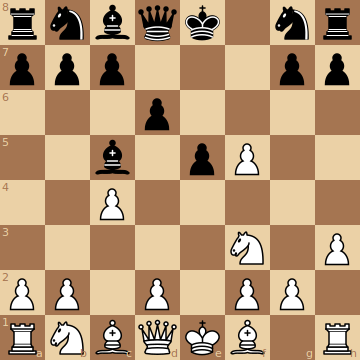

Idx 11336128 Eval -0.25 Prediction -9.79 Loss 9.54
FEN 4r3/1p3pKP/p4Bp1/5kP1/8/8/bP6/8 b - - 0 39


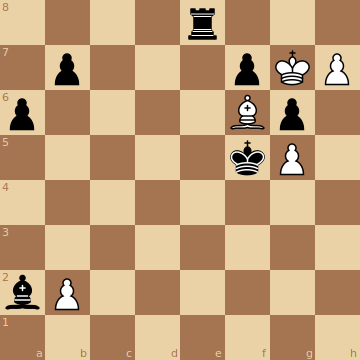

Idx 7030110 Eval 11.65 Prediction 12.68 Loss 1.03
FEN 4r1k1/ppR2pp1/7p/5Q2/3N4/4P3/q4PPP/2R3K1 b - - 1 24


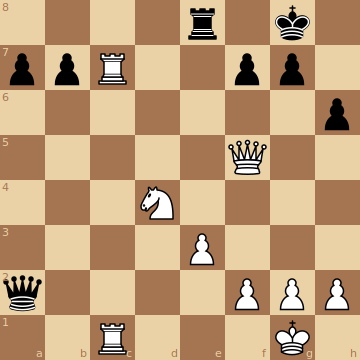

Idx 31631820 Eval 0.37 Prediction -0.36 Loss 0.73
FEN 8/1p3bkp/1Qp2p2/8/5P2/3n2P1/4q1BP/5R1K b - - 0 28


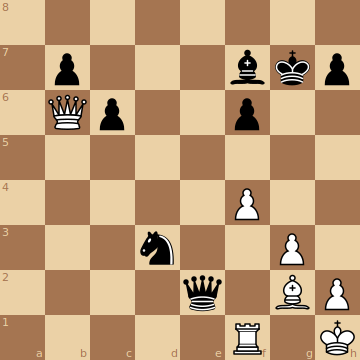

Idx 21302889 Eval -5.81 Prediction -7.12 Loss 1.31
FEN 2krr3/4n2p/p1pb2p1/1p3b2/1P1N1P2/P7/1P4PP/R1B1R2K b - - 0 23


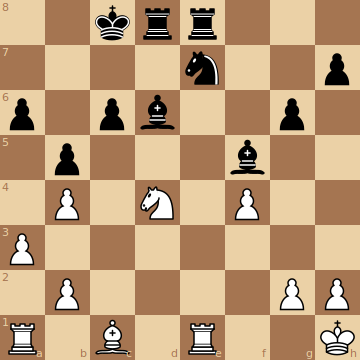

Idx 27177543 Eval -6.07 Prediction -7.72 Loss 1.65
FEN 1k1r4/1pp1n2p/p1n3p1/4P3/5B2/1Q3qP1/P4P1P/KR6 b - - 1 25


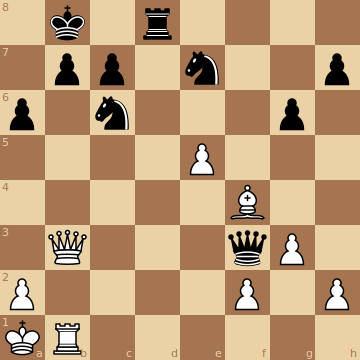

Idx 19425971 Eval -1.95 Prediction -5.65 Loss 3.70
FEN 4n3/1k4bp/1p4p1/8/p2PRB2/1qP3P1/5P1P/2R3K1 b - - 0 34


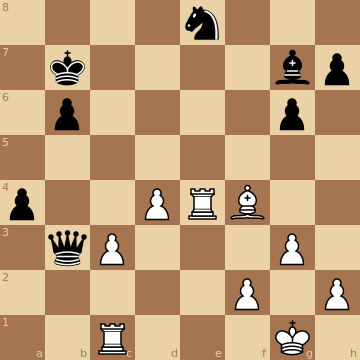

Idx 18026913 Eval 1.05 Prediction 1.16 Loss 0.11
FEN rb2r1k1/1pq2ppp/2n3b1/p2Q4/8/P3PN1P/1P2BPP1/R1B2RK1 w - - 1 21


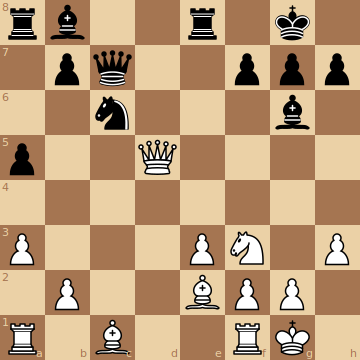

In [8]:
from IPython.display import display, SVG
from random import randrange

SVG_BASE_URL = "https://us-central1-spearsx.cloudfunctions.net/chesspic-fen-image/" 

def svg_url(fen):
  fen_board = fen.split()[0]
  return SVG_BASE_URL + fen_board

def show_index(idx):
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  batch = dataset[idx]
  x, y = torch.tensor(batch['binary']), torch.tensor(batch['eval'])
  y_hat = model(x)
  loss = F.l1_loss(y_hat, y)
  print(f'Idx {idx} Eval {y.data[0]:.2f} Prediction {y_hat.data[0]:.2f} Loss {loss:.2f}')
  print(f'FEN {eval.fen}')
  display(SVG(url=svg_url(eval.fen)))

for i in range(15):
  idx = randrange(LABEL_COUNT)
  show_index(idx)

In [9]:
import chess

MATERIAL_LOOKUP = { chess.KING: 0, chess.QUEEN: 9, chess.ROOK: 5, chess.BISHOP: 3, chess.KNIGHT: 3, chess.PAWN: 1 }

def avg(lst):
  return sum(lst) / len(lst)

def material_for_board(board):
  eval = 0.0
  for sq, piece in board.piece_map().items():
    mat = MATERIAL_LOOKUP[piece.piece_type] 
    if piece.color == chess.BLACK:
      mat = mat * -1
    eval += mat
  return eval
  
def guess_zero_loss(idx):
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  y = torch.tensor(eval.eval)
  y_hat = torch.zeros_like(y)
  loss = F.l1_loss(y_hat, y)
  return loss

def guess_material_loss(idx):
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  board = chess.Board(eval.fen)
  y = torch.tensor(eval.eval)
  y_hat = torch.tensor(material_for_board(board))
  loss = F.l1_loss(y_hat, y)
  return loss

def guess_model_loss(idx):
  batch = dataset[idx]
  x, y = torch.tensor(batch['binary']), torch.tensor(batch['eval'])
  y_hat = model(x)
  loss = F.l1_loss(y_hat, y)
  return loss

zero_losses = []
mat_losses = []
model_losses = []
for i in range(100):
  idx = randrange(LABEL_COUNT)
  zero_losses.append(guess_zero_loss(idx))
  mat_losses.append(guess_material_loss(idx))
  model_losses.append(guess_model_loss(idx))


print(f'Guess Zero Avg Loss {avg(zero_losses)}')
print(f'Guess Material Avg Loss {avg(mat_losses)}')
print(f'Guess Model Avg Loss {avg(model_losses)}')

Guess Zero Avg Loss 8.036300659179688
Guess Material Avg Loss 5.898699760437012
Guess Model Avg Loss 1.6450626850128174


In [10]:
version_name = f'{int(time.time())}-batch_size-512-layer_count-10'
logger = pl.loggers.TensorBoardLogger("lightning_logs", name="chessml", version=version_name)
trainer = pl.Trainer(precision='16-mixed', max_epochs=1, accelerator='gpu')
model = EvaluationModel(layer_count=16, batch_size=512, learning_rate=1e-3)
print(model)
summary(model, (808,), device='cpu')
trainer.fit(model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | seq  | Sequential | 9.8 M 
------------------------------------
9.8 M     Trainable params
0         Non-trainable params
9.8 M     Total params
39.224    Total estimated model params size (MB)


EvaluationModel(
  (seq): Sequential(
    (linear-0): Linear(in_features=808, out_features=808, bias=True)
    (relu-0): ReLU()
    (linear-1): Linear(in_features=808, out_features=808, bias=True)
    (relu-1): ReLU()
    (linear-2): Linear(in_features=808, out_features=808, bias=True)
    (relu-2): ReLU()
    (linear-3): Linear(in_features=808, out_features=808, bias=True)
    (relu-3): ReLU()
    (linear-4): Linear(in_features=808, out_features=808, bias=True)
    (relu-4): ReLU()
    (linear-5): Linear(in_features=808, out_features=808, bias=True)
    (relu-5): ReLU()
    (linear-6): Linear(in_features=808, out_features=808, bias=True)
    (relu-6): ReLU()
    (linear-7): Linear(in_features=808, out_features=808, bias=True)
    (relu-7): ReLU()
    (linear-8): Linear(in_features=808, out_features=808, bias=True)
    (relu-8): ReLU()
    (linear-9): Linear(in_features=808, out_features=808, bias=True)
    (relu-9): ReLU()
    (linear-10): Linear(in_features=808, out_features=808, bia

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 72588/72588 [2:25:13<00:00,  8.33it/s, v_num=2]


Idx 34971480 Eval -6.48 Prediction -7.58 Loss 1.10
FEN r2qr1k1/1bp2ppp/p2b4/1p1P1P2/6Q1/2N5/PPP3PP/2R2R1K b - - 2 20


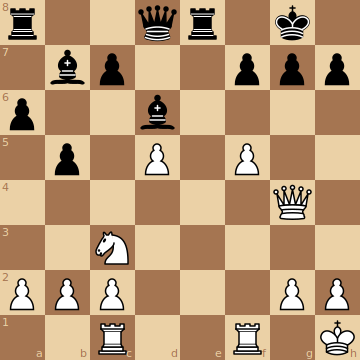

Idx 30379255 Eval -15.00 Prediction 0.01 Loss 15.01
FEN 8/6p1/4pk1p/1Q2p3/2p1P3/2P2PK1/1P1q2PP/8 b - - 0 38


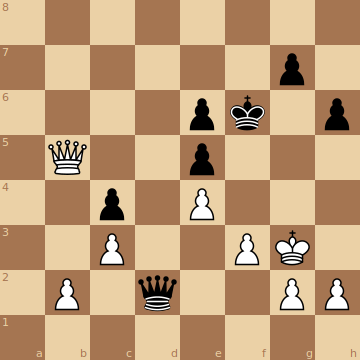

Idx 15296651 Eval 0.67 Prediction 1.06 Loss 0.39
FEN rn1qk2r/pbp1bppp/1p2pn2/8/2BP1B2/2N1PN2/PP3PPP/R2QK2R w KQkq - 1 8


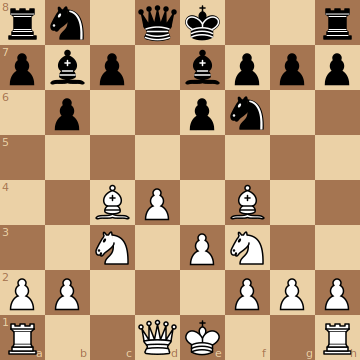

Idx 5499083 Eval 0.00 Prediction 0.00 Loss 0.00
FEN 5Q2/p6k/1p2p2p/3p4/8/7P/P3q1P1/7K w - - 5 32


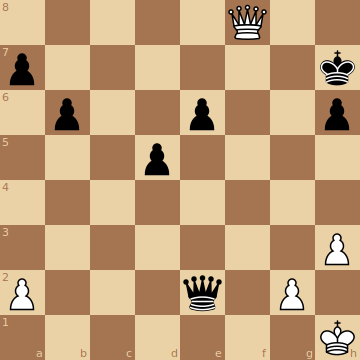

Idx 13358303 Eval 0.56 Prediction 0.17 Loss 0.39
FEN r3k2r/2p1q2p/p4ppB/1p3b2/3pN3/1B1P4/PP1N1PPP/R3K2R b KQkq - 2 17


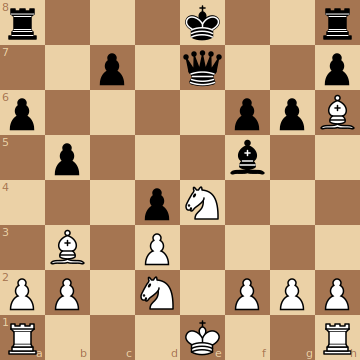

Idx 7445005 Eval -3.25 Prediction -5.08 Loss 1.83
FEN 2nr4/5k2/3p1pp1/1ppP2nb/4P3/PP4Q1/2B5/2K5 w - - 5 36


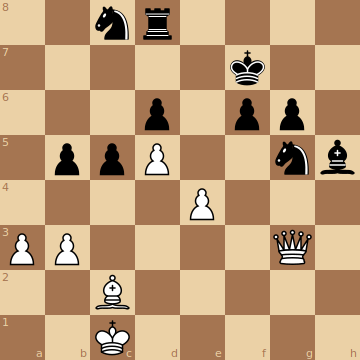

Idx 1043121 Eval -1.05 Prediction -0.55 Loss 0.50
FEN r3kbnr/1pp1pppp/p1nq4/1B1p1b2/3P1P2/N3P3/PPP3PP/R1BQK1NR w KQkq - 0 6


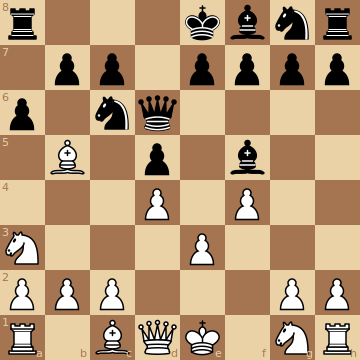

Idx 21451238 Eval -4.79 Prediction -4.52 Loss 0.27
FEN 3r4/1p3kpp/pq1p1p1b/2r1p3/2P1P2P/1P1Q2P1/P4P2/3R1RK1 b - - 2 22


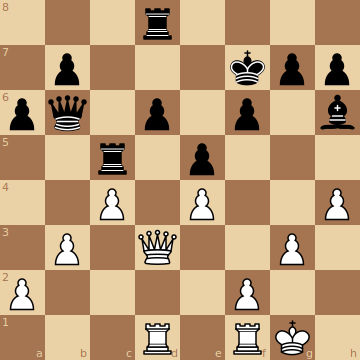

Idx 26874532 Eval -3.79 Prediction 1.39 Loss 5.18
FEN r4rk1/2p2pp1/b3p2p/1QPpN1q1/3Pn3/4P3/P4PPP/RN3RK1 w - - 3 19


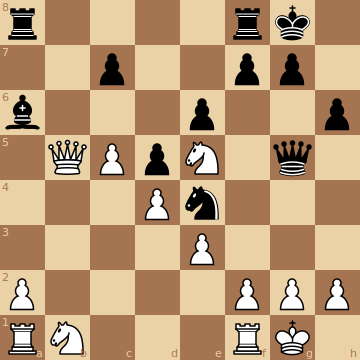

Idx 8614342 Eval 2.50 Prediction 1.75 Loss 0.75
FEN r1bqk2r/pp3ppp/2nb1n2/2pN4/2B5/3P1Q2/PPP2PPP/R1B1K1NR w KQkq - 1 8


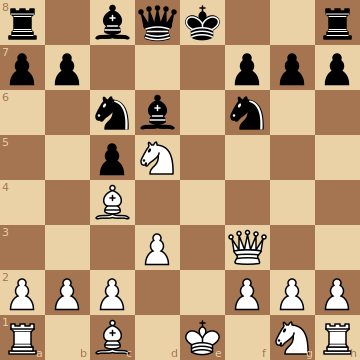

Idx 26769338 Eval -6.45 Prediction -7.07 Loss 0.62
FEN 6k1/5q1p/p5p1/1p1pP3/2p5/P7/1PP2P2/1K4R1 b - - 0 30


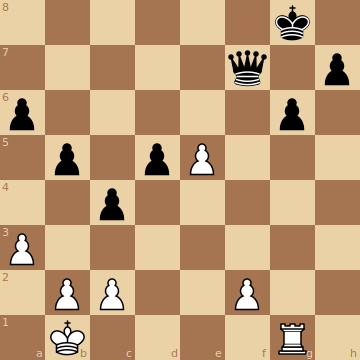

Idx 33393927 Eval -5.61 Prediction 0.48 Loss 6.09
FEN 8/8/p5p1/1kPp1p2/2pB1n1P/2P4P/PK6/8 w - - 0 44


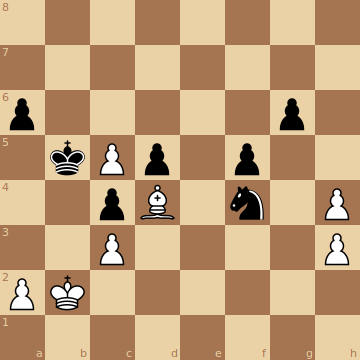

Idx 17295091 Eval -6.41 Prediction -2.14 Loss 4.27
FEN 3rr1k1/p3bpp1/b3p2p/q1p1B3/4p3/1QR1P3/PP3PPP/1B2K2R w K - 6 21


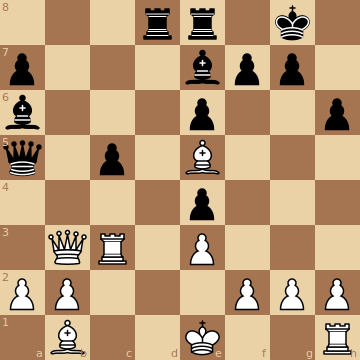

Idx 10256068 Eval -6.37 Prediction -4.66 Loss 1.71
FEN 3q2k1/1r3ppp/p1p1rn2/1pP2Q2/1P1P4/P2R2P1/5P1P/3R2K1 w - - 6 31


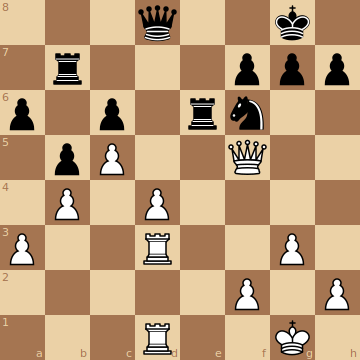

Idx 1620901 Eval 15.00 Prediction 14.98 Loss 0.02
FEN 8/8/7K/7P/5k2/5P2/8/8 w - - 1 73


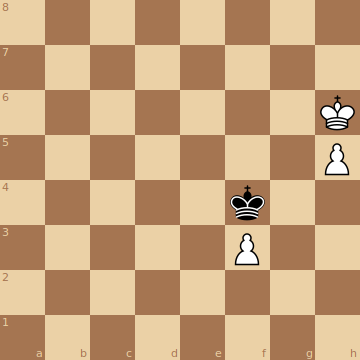

In [11]:
from IPython.display import display, SVG
from random import randrange

SVG_BASE_URL = "https://us-central1-spearsx.cloudfunctions.net/chesspic-fen-image/" 

def svg_url(fen):
  fen_board = fen.split()[0]
  return SVG_BASE_URL + fen_board

def show_index(idx):
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  batch = dataset[idx]
  x, y = torch.tensor(batch['binary']), torch.tensor(batch['eval'])
  y_hat = model(x)
  loss = F.l1_loss(y_hat, y)
  print(f'Idx {idx} Eval {y.data[0]:.2f} Prediction {y_hat.data[0]:.2f} Loss {loss:.2f}')
  print(f'FEN {eval.fen}')
  display(SVG(url=svg_url(eval.fen)))

for i in range(15):
  idx = randrange(LABEL_COUNT)
  show_index(idx)

In [12]:
import chess

MATERIAL_LOOKUP = { chess.KING: 0, chess.QUEEN: 9, chess.ROOK: 5, chess.BISHOP: 3, chess.KNIGHT: 3, chess.PAWN: 1 }

def avg(lst):
  return sum(lst) / len(lst)

def material_for_board(board):
  eval = 0.0
  for sq, piece in board.piece_map().items():
    mat = MATERIAL_LOOKUP[piece.piece_type] 
    if piece.color == chess.BLACK:
      mat = mat * -1
    eval += mat
  return eval
  
def guess_zero_loss(idx):
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  y = torch.tensor(eval.eval)
  y_hat = torch.zeros_like(y)
  loss = F.l1_loss(y_hat, y)
  return loss

def guess_material_loss(idx):
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  board = chess.Board(eval.fen)
  y = torch.tensor(eval.eval)
  y_hat = torch.tensor(material_for_board(board))
  loss = F.l1_loss(y_hat, y)
  return loss

def guess_model_loss(idx):
  batch = dataset[idx]
  x, y = torch.tensor(batch['binary']), torch.tensor(batch['eval'])
  y_hat = model(x)
  loss = F.l1_loss(y_hat, y)
  return loss

zero_losses = []
mat_losses = []
model_losses = []
for i in range(100):
  idx = randrange(LABEL_COUNT)
  zero_losses.append(guess_zero_loss(idx))
  mat_losses.append(guess_material_loss(idx))
  model_losses.append(guess_model_loss(idx))


print(f'Guess Zero Avg Loss {avg(zero_losses)}')
print(f'Guess Material Avg Loss {avg(mat_losses)}')
print(f'Guess Model Avg Loss {avg(model_losses)}')

Guess Zero Avg Loss 6.627201080322266
Guess Material Avg Loss 4.501399040222168
Guess Model Avg Loss 1.5671473741531372


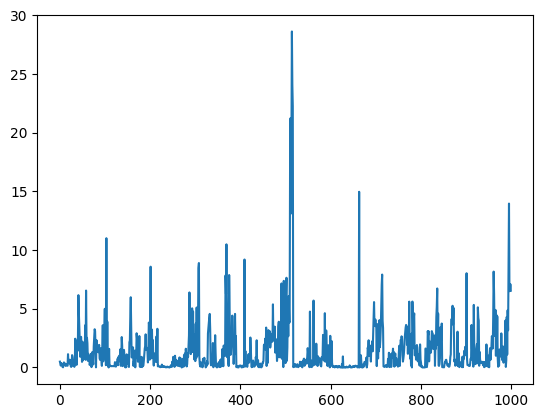

In [32]:
import matplotlib.pyplot as plt

model_losses = []

for idx in range(1000):
  loss = guess_model_loss(idx)
  model_losses.append(torch.Tensor.detach(loss).numpy())

plt.plot(model_losses)

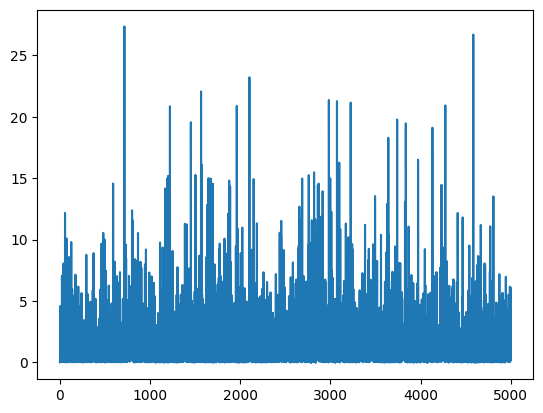

In [34]:
import matplotlib.pyplot as plt

model_losses = []

for i in range(5000):
  idx = randrange(LABEL_COUNT)
  loss = guess_model_loss(idx)
  model_losses.append(torch.Tensor.detach(loss).numpy())

plt.plot(model_losses)

In [49]:
from sklearn.metrics import  mean_squared_error, r2_score, log_loss

y_list = []
y_pred = []

for i in range(1000000, 1010001):
  batch = dataset[i]
  x, y = torch.tensor(batch['binary']), torch.tensor(batch['eval'])
  y_hat = model(x)
  y_list.append(torch.Tensor.detach(y).numpy())
  y_pred.append(torch.Tensor.detach(y_hat).numpy())

print(mean_squared_error(y_list, y_pred))
print(r2_score(y_list, y_pred))

9.32608
0.8045563224210164
